In [1]:
# ───────────────────────────────
# 📦 Standard Libraries
# ───────────────────────────────
import os
import sys
import math
import time
import csv
import pickle
from datetime import datetime, timedelta
from collections import Counter

# ───────────────────────────────
# 📚 Data Handling & Utilities
# ───────────────────────────────
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import h5py
from joblib import dump, load

# ───────────────────────────────
# 📊 Visualization
# ───────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────
# 📈 Machine Learning
# ───────────────────────────────
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_curve, roc_auc_score, auc,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# ───────────────────────────────
# 🌍 Seismology & Signal Processing
# ───────────────────────────────
import obspy
from obspy import UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.fdsn import Client
from obspy.signal.filter import envelope
from scipy import stats, signal

# ───────────────────────────────
# 🔗 External Tools
# ───────────────────────────────
from zenodo_get import zenodo_get

# ───────────────────────────────
# 🤖 Deep Learning
# ───────────────────────────────
import torch
import torch.nn.functional as F


# ───────────────────────────────
# 🛠 Custom Utilities
# ───────────────────────────────
sys.path.insert(0, '/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts')
from neural_network_architectures import SeismicCNN_2d

from utils import (
    extract_waveforms,
    compute_spectrogram,
    normalize_spectrogram_minmax,
    return_train_val_loaders,
    plot_confusion_matrix_and_cr,
    train_model,
    WaveformPreprocessor
)

# Pandas display options
pd.set_option('display.max_columns', None)


sys.path.append('/home/ak287/seisbench/seisbench/models')
import seisbench.models as sbm



# for extracting unique stations
import re
from pathlib import Path

cuda


In [2]:
# Function to extract information
def extract_datetime_info(date_str):
    date_obj = datetime.strptime(date_str, '%Y_%m_%d %H%M%S')
    hour_of_day = date_obj.hour - 8
    day_of_week = date_obj.weekday()  # Full day name
    month_of_year = date_obj.month  # Full month name
    return hour_of_day, day_of_week, month_of_year



def conv_to_datetime(df):
    new_df = []
    for i in range(len(df)):
        year = int(df[i].split('_')[0])
        month = int(df[i].split('_')[1])
        day = int(df[i].split('_')[2].split(' ')[0])
        hour = int(df[i].split('_')[2].split(' ')[1][0:2])
        minute = int(df[i].split('_')[2].split(' ')[1][2:4])
        second = int(df[i].split('_')[2].split(' ')[1][4:])
        new_df.append(obspy.UTCDateTime(year, month, day, hour, minute, second))
        
    return np.array(new_df)

## Loading the older catalog. 

In [3]:
pd.set_option('display.max_columns', None)
cat_all_old = pd.read_csv('../../data/IRISExoticEventCatalog.txt', sep='|')
cat_old = cat_all_old.copy()
cat_old

,areaSource,areaSourceHigh,areaSourceLow,areaTotal,associationId,datlocation,depth,endtime,eventid,h,hHigh,hLow,hfall,hfall_high,hfall_low,l,lHigh,lLow,latitude,locuncertKm,longitude,lppotential,mass,massHigh,massLow,maxdistvhfKm,maxdistvhfReached,maxdisthfKm,maxdisthfReached,maxdistipKm,maxdistipReached,maxdistlpKm,maxdistlpReached,maxdistinfraKm,maxdistinfraReached,infraDetected,name,otherdataquality1to5,peakDischarge,peakDischargeLow,peakDischargeHigh,peakFlowheight,peakFlowheightLow,peakFlowheightHigh,starttime,sources,toeLat,toeLon,topLat,topLon,upstreamDrainarea,type,subtype,volume,volumeHigh,volumeLow
0,NaN,NaN,NaN,NaN,22,IRIS,NaN,2007_07_25 010251,22,1860.0,NaN,NaN,NaN,NaN,NaN,5760.0,NaN,NaN,61.10249,0.00,-140.30550,1,1.080000e+11,NaN,NaN,NaN,NaN,1079.0,True,NaN,NaN,1100.0,False,NaN,NaN,NaN,Mount Steele 2,5,NaN,NaN,NaN,NaN,NaN,NaN,2007_07_25 005835,"Allstadt, Kate E., McVey, Brennah G., and Malo...",61.14054,-140.25324,61.10249,-140.30550,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,54000000.0,80500000.0,27500000.0
1,NaN,NaN,NaN,NaN,218,"RESIF, ETH, ORFEUS, LMU, BGR, IRIS, INGV",NaN,2017_08_23 093828,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.29552,NaN,9.60190,0,NaN,NaN,NaN,NaN,NaN,246.0,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN,"Piz Cengalo 4, Switzerland",1,NaN,NaN,NaN,NaN,NaN,NaN,2017_08_23 093617,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,landslide,Rock/ice/debris avalanches and slides,NaN,NaN,NaN
2,111000.0,NaN,NaN,1130000.0,127,IRIS,NaN,2017_07_22 205957,127,931.0,NaN,NaN,NaN,NaN,NaN,3730.0,NaN,NaN,60.07385,0.00,-139.84532,1,NaN,NaN,NaN,NaN,NaN,351.0,False,NaN,NaN,386.0,False,0.0,NaN,False,Lucia Glacier,4,NaN,NaN,NaN,NaN,NaN,NaN,2017_07_22 205630,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",60.06616,-139.90755,60.07385,-139.84532,NaN,rock avalanche,Rock/ice/debris avalanches and slides,3000000.0,4000000.0,2300000.0
3,100000.0,150000.0,65000.0,820000.0,186,"IRIS, NCEDC",NaN,2013_07_25 101727,186,690.0,760.0,640.0,NaN,NaN,NaN,2000.0,2100.0,1600.0,61.98450,0.00,-143.16830,1,4.000000e+10,NaN,NaN,NaN,NaN,500.0,False,NaN,NaN,500.0,False,NaN,NaN,NaN,Wrangell Mountains,4,NaN,NaN,NaN,NaN,NaN,NaN,2013_07_25 101456,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",61.97220,-143.14950,61.98450,-143.16830,NaN,rock and debris avalanche,Rock/ice/debris avalanches and slides,2600000.0,3900000.0,1800000.0
4,23400.0,NaN,NaN,NaN,147,IRIS,NaN,2019_05_13 144245,147,1240.0,NaN,NaN,NaN,NaN,NaN,4320.0,NaN,NaN,50.34480,0.00,-122.45110,1,NaN,NaN,NaN,NaN,NaN,391.0,True,NaN,NaN,301.0,True,NaN,NaN,NaN,Mount Joffre 1,5,NaN,NaN,NaN,NaN,NaN,NaN,2019_05_13 143955,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",50.36720,-122.41540,50.34480,-122.45110,NaN,"rock avalanche, debris flow",Rock/ice/debris avalanches and slides,1900000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,NaN,NaN,NaN,NaN,185,Attachments below,NaN,2015_06_09 160558,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.67199,NaN,10.72268,0,NaN,NaN,NaN,3.0,NaN,3.0,True,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Gadria 3,5,27.0,NaN,NaN,1.7,NaN,NaN,2015_06_09 151558,"Coviello, V., Arattano, M., Comiti, F., Maccon...",NaN,NaN,NaN,NaN,6.3,debris flow,Lahar/debris flow/outburst flood,12600.0,NaN,NaN
241,310000.0,520000.0,200000.0,7900000.0,19,IRIS,NaN,2012_06_11 222652,19,2400.0,2500.0,2300.0,NaN,NaN,NaN,9300.0,9500.0,9100.0,58.79367,0.00,-137.44247,1,2.000000e+10,NaN,NaN,NaN,NaN,890.0,True,NaN,NaN,1000.0,False,NaN,NaN,NaN,Mount Lituya main,4,NaN,NaN,NaN,NaN,NaN,NaN,2012_06_11 222400,"Allstadt, Kate E., McVey, Brennah G., and Malo...",58.81626,-137.30032,58.79367,-137.44247,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,13000000.0,60000000.0,2800000.0
242,130000.0,160000.0,84000.0,3000000.0,188,"IRIS, NCEDC",NaN,2010_07_09 073820,188,1800.0,1900.0,

## Loading the newer catalog. 

In [4]:
pd.set_option('display.max_columns', None)
cat_all_new = pd.read_csv('../../src/IRIS_DMC_esecEventsDb_updated.txt', sep='|')
cat_new = cat_all_new.copy()
cat_new

,areaSource,areaSourceHigh,areaSourceLow,areaTotal,associationId,datlocation,depth,endtime,eventid,h,hHigh,hLow,hfall,hfall_high,hfall_low,l,lHigh,lLow,latitude,locuncertKm,longitude,lppotential,mass,massHigh,massLow,maxdistvhfKm,maxdistvhfReached,maxdisthfKm,maxdisthfReached,maxdistipKm,maxdistipReached,maxdistlpKm,maxdistlpReached,maxdistinfraKm,maxdistinfraReached,infraDetected,name,otherdataquality1to5,peakDischarge,peakDischargeLow,peakDischargeHigh,peakFlowheight,peakFlowheightLow,peakFlowheightHigh,starttime,sources,toeLat,toeLon,topLat,topLon,upstreamDrainarea,type,subtype,volume,volumeHigh,volumeLow
0,NaN,NaN,NaN,NaN,22,IRIS,NaN,2007_07_25 010251,22,1860.0,NaN,NaN,NaN,NaN,NaN,5760.0,NaN,NaN,61.10249,0.00,-140.30550,1,1.080000e+11,NaN,NaN,NaN,NaN,1079.0,True,NaN,NaN,1100.0,False,NaN,NaN,NaN,Mount Steele 2,5,NaN,NaN,NaN,NaN,NaN,NaN,2007_07_25 005835,"Allstadt, Kate E., McVey, Brennah G., and Malo...",61.14054,-140.25324,61.10249,-140.30550,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,54000000.0,80500000.0,27500000.0
1,100000.0,NaN,NaN,1600000.0,273,IRIS,NaN,2017_06_23 214249,273,1200.0,NaN,NaN,NaN,NaN,NaN,2600.0,NaN,NaN,32.07970,0.00,103.66280,1,NaN,NaN,NaN,NaN,NaN,591.0,False,NaN,NaN,591.0,False,NaN,NaN,NaN,"Xinmo Village, China",5,NaN,NaN,NaN,NaN,NaN,NaN,2017_06_23 213916,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,"rock slide, rock avalanche",Rock/ice/debris avalanches and slides,13000000.0,14000000.0,12000000.0
2,NaN,NaN,NaN,NaN,218,"RESIF, ETH, ORFEUS, LMU, BGR, IRIS, INGV",NaN,2017_08_23 093828,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.29552,NaN,9.60190,0,NaN,NaN,NaN,NaN,NaN,246.0,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN,"Piz Cengalo 4, Switzerland",1,NaN,NaN,NaN,NaN,NaN,NaN,2017_08_23 093617,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,landslide,Rock/ice/debris avalanches and slides,NaN,NaN,NaN
3,111000.0,NaN,NaN,1130000.0,127,IRIS,NaN,2017_07_22 205957,127,931.0,NaN,NaN,NaN,NaN,NaN,3730.0,NaN,NaN,60.07385,0.00,-139.84532,1,NaN,NaN,NaN,NaN,NaN,351.0,False,NaN,NaN,386.0,False,0.0,NaN,False,Lucia Glacier,4,NaN,NaN,NaN,NaN,NaN,NaN,2017_07_22 205630,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",60.06616,-139.90755,60.07385,-139.84532,NaN,rock avalanche,Rock/ice/debris avalanches and slides,3000000.0,4000000.0,2300000.0
4,NaN,NaN,NaN,10000000.0,285,IRIS,NaN,1997_12_26 070719,285,NaN,NaN,NaN,NaN,NaN,NaN,4000.0,NaN,NaN,16.70900,0.10,-62.17620,1,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,450.0,False,NaN,NaN,NaN,Montserrat,5,NaN,NaN,NaN,NaN,NaN,NaN,1997_12_26 070240,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",16.67530,-62.17620,16.70900,-62.17620,NaN,"debris avalanche, pyroclastic density current",Rock/ice/debris avalanches and slides,46000000.0,50000000.0,40000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,3500000.0,NaN,NaN,NaN,275,IRIS,NaN,2009_08_10 110853,275,1500.0,NaN,NaN,NaN,NaN,NaN,7200.0,7500.0,7000.0,23.22810,0.00,120.75170,1,NaN,NaN,NaN,NaN,NaN,208.0,True,NaN,NaN,277.0,False,NaN,NaN,NaN,"Butangbunasi, Taiwan",5,NaN,NaN,NaN,NaN,NaN,NaN,2009_08_10 110556,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",23.18310,120.77820,23.22810,120.75170,NaN,landslide,Rock/ice/debris avalanches and slides,83800000.0,NaN,NaN
315,NaN,NaN,NaN,NaN,319,"NCEDC, IRIS",NaN,2022_08_03 032337,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.39070,1.00,-122.18550,0,NaN,NaN,NaN,0.0,NaN,14.0,False,NaN,NaN,0.0,NaN,NaN,NaN,False,"Mud Creek, Mount Shasta",3,NaN,NaN,NaN,NaN,NaN,NaN,2022_08_03 012901,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,debris flow,Lahar/debris flow/outburst flood,NaN,NaN,NaN
316,130000.0,160000.0,84000.0,3000000.0,188,"IRIS, NCEDC",NaN,2010_07_09 073820,188,1800.0,1900.0,1600.0,NaN,NaN,NaN,7600.0,7900.0,7300.0,51.87130,0.00,-125.94340

## Testing the retrained models on new events

In [5]:
cat_test = cat_new.merge(
    cat_old.drop_duplicates(),        # just in case cat_old has duplicates
    how="left",
    indicator=True
).query('_merge == "left_only"') \
  .drop(columns='_merge')             # (_merge was just for filtering)



# 1️⃣  Build the sets once
ids_test = set(cat_test['eventid'])
ids_old  = set(cat_old['eventid'])

# 2️⃣  Find and display every overlapping ID
overlap = ids_test & ids_old
print(f"🔍  Overlap count: {len(overlap)}")
if overlap:
    print("Overlapping eventid(s):", sorted(overlap))

# 3️⃣  Option A – DROP the overlaps from cat_test
cat_test_clean = cat_test[~cat_test['eventid'].isin(overlap)].copy()

# ───────────────────────────────────────────────────────────────
# If you’d rather regenerate your split instead of dropping, do it
# here (e.g. re-sample from cat_new after excluding cat_old).
# ───────────────────────────────────────────────────────────────

# 4️⃣  Final safety check
assert not cat_test_clean['eventid'].isin(cat_old['eventid']).any(), \
       "Overlap still present!"

print("✅  cat_test is now disjoint from cat_old.")

cat = cat_test_clean.copy()

🔍  Overlap count: 6
Overlapping eventid(s): [4, 23, 59, 81, 166, 192]
✅  cat_test is now disjoint from cat_old.


In [6]:
event_ids = cat['eventid'].values
source_types = cat['type'].values
source_subtypes = cat['subtype'].values

In [7]:
hod = [extract_datetime_info(i)[0] for i in cat['starttime'].values]
dow = [extract_datetime_info(i)[1] for i in cat['starttime'].values]
moy = [extract_datetime_info(i)[2] for i in cat['starttime'].values]

In [8]:
cat['starttime']

1      2017_06_23 213916
4      1997_12_26 070240
6      2013_01_21 010828
18     2020_07_24 214125
28     2021_07_27 172215
             ...        
296    2022_09_01 204553
306    2023_09_16 123545
312    2022_09_01 205421
314    2009_08_10 110556
315    2022_08_03 012901
Name: starttime, Length: 74, dtype: object

In [9]:
cat = cat.reset_index(drop = True)
## computing the durations
sttime = cat['starttime']
ettime = cat['endtime']

starttimes = conv_to_datetime(sttime)
endtimes = conv_to_datetime(ettime)
dur = conv_to_datetime(ettime) - conv_to_datetime(sttime)

In [10]:
cat

,areaSource,areaSourceHigh,areaSourceLow,areaTotal,associationId,datlocation,depth,endtime,eventid,h,hHigh,hLow,hfall,hfall_high,hfall_low,l,lHigh,lLow,latitude,locuncertKm,longitude,lppotential,mass,massHigh,massLow,maxdistvhfKm,maxdistvhfReached,maxdisthfKm,maxdisthfReached,maxdistipKm,maxdistipReached,maxdistlpKm,maxdistlpReached,maxdistinfraKm,maxdistinfraReached,infraDetected,name,otherdataquality1to5,peakDischarge,peakDischargeLow,peakDischargeHigh,peakFlowheight,peakFlowheightLow,peakFlowheightHigh,starttime,sources,toeLat,toeLon,topLat,topLon,upstreamDrainarea,type,subtype,volume,volumeHigh,volumeLow
0,100000.0,NaN,NaN,1600000.0,273,IRIS,NaN,2017_06_23 214249,273,1200.0,NaN,NaN,NaN,NaN,NaN,2600.0,NaN,NaN,32.0797,0.0,103.66280,1,NaN,NaN,NaN,NaN,NaN,591.0,False,NaN,NaN,591.0,False,NaN,NaN,NaN,"Xinmo Village, China",5,NaN,NaN,NaN,NaN,NaN,NaN,2017_06_23 213916,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,"rock slide, rock avalanche",Rock/ice/debris avalanches and slides,13000000.0,14000000.0,12000000.0
1,NaN,NaN,NaN,10000000.0,285,IRIS,NaN,1997_12_26 070719,285,NaN,NaN,NaN,NaN,NaN,NaN,4000.0,NaN,NaN,16.7090,0.1,-62.17620,1,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,450.0,False,NaN,NaN,NaN,Montserrat,5,NaN,NaN,NaN,NaN,NaN,NaN,1997_12_26 070240,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",16.6753,-62.1762,16.7090,-62.1762,NaN,"debris avalanche, pyroclastic density current",Rock/ice/debris avalanches and slides,46000000.0,50000000.0,40000000.0
2,NaN,NaN,NaN,NaN,277,IRIS,NaN,2013_01_21 011052,277,900.0,NaN,NaN,NaN,NaN,NaN,2900.0,NaN,NaN,-43.5611,0.0,170.18010,2,NaN,NaN,NaN,NaN,NaN,73.0,False,NaN,NaN,56.0,False,NaN,NaN,NaN,"Mount Haast, New Zealand",5,NaN,NaN,NaN,NaN,NaN,NaN,2013_01_21 010828,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",-43.5857,170.1764,-43.5611,170.1801,NaN,rock avalanche,Rock/ice/debris avalanches and slides,2000000.0,NaN,NaN
3,NaN,NaN,NaN,NaN,276,IRIS,NaN,2020_07_24 221811,276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.2600,0.0,-111.62292,0,NaN,NaN,NaN,2.0,1.0,2.0,True,NaN,NaN,0.0,NaN,NaN,NaN,NaN,"Museum Fire, Arizona",5,NaN,3.0,6.0,NaN,NaN,NaN,2020_07_24 214125,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,debris flow,Lahar/debris flow/outburst flood,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,280,"NCEDC, IRIS",NaN,2021_07_28 025915,280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.4197,0.6,-122.21150,0,NaN,NaN,NaN,9.0,1.0,9.0,True,NaN,NaN,0.0,NaN,0.0,NaN,NaN,"Whitney and Bolam Creek, Mount Shasta",4,NaN,NaN,NaN,NaN,NaN,NaN,2021_07_27 172215,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,debris flow,Lahar/debris flow/outburst flood,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,NaN,NaN,NaN,NaN,296,IRIS,NaN,2022_09_01 204705,296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.1985,0.4,-122.17590,0,NaN,NaN,NaN,NaN,NaN,4.0,True,NaN,NaN,0.0,NaN,NaN,NaN,False,Mount St Helens 1,1,NaN,NaN,NaN,NaN,NaN,NaN,2022_09_01 204553,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,rock fall,Rock/debris falls,NaN,NaN,NaN
70,160000.0,NaN,NaN,NaN,322,"IRIS, GEOFON",NaN,2023_09_16 124211,322,350.0,400.0,300.0,NaN,NaN,NaN,2200.0,NaN,1600.0,72.8080,0.0,-26.94400,1,5.500000e+10,1.030000e+11,NaN,NaN,NaN,957.0,False,NaN,NaN,957.0,False,3310.0,False,True,"Dickson Fjord, Greenland",5,NaN,NaN,NaN,NaN,NaN,NaN,2023_09_16 123545,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,"rock slide, rock and ice avalanche",Rock/ice/debris avalanches and slides,25500000.0,27500000.0,23800000.0
71,NaN,NaN,NaN,NaN,297,IRIS,NaN,2022_09_01 205627,297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.2049,0.4,-122.17420,0,NaN,NaN,NaN,NaN,NaN,5.0,True,NaN,NaN,0.0,NaN,NaN,NaN,False,Mount St Helens 2,1,NaN,NaN,NaN,NaN,NaN,NaN,2022_09_01 205421,"Collins, E.A., Allstadt, K.E., Groul

In [11]:
cat.to_csv('cat_new_esec.csv')

## Loading the deep learning models

In [12]:
## Loading the quakexnet model. 

model3_sc = sbm.SeismicCNN.from_pretrained("base", version_str = '3')
model3_qx = sbm.QuakeXNet.from_pretrained("base", version_str = '3')

## Some helpful functions  for event detections

In [13]:
# we want to smoothen out the probabilities here. 
def smooth_moving_avg(x, window=5):
    pad_width = window // 2
    padded = np.pad(x, (pad_width, pad_width), mode='edge')
    kernel = np.ones(window) / window
    return np.convolve(padded, kernel, mode='valid')






def detect_event_windows(prob_series, enter_thr=0.15, exit_thr=0.15, peak_thr=0.5):
    in_event = False
    events = []
    start = None
    max_val = -np.inf
    running_vals = []

    for i, val in enumerate(prob_series):
        if not in_event and val >= enter_thr:
            start = i
            max_val = val
            running_vals = [val]
            in_event = True
        elif in_event:
            running_vals.append(val)
            max_val = max(max_val, val)
            if val < exit_thr:
                end = i
                if max_val >= peak_thr:
                    mean_val = np.mean(running_vals)
                    auc = np.trapz(running_vals)  # Area under the curve
                    events.append({
                        "start": start,
                        "end": end,
                        "max_prob": max_val,
                        "mean_prob": mean_val,
                        "area_under_curve": auc
                    })
                in_event = False

    # Handle if still in event at end of series
    if in_event and max_val >= peak_thr:
        mean_val = np.mean(running_vals)
        auc = np.trapz(running_vals)
        events.append({
            "start": start,
            "end": len(prob_series) - 1,
            "max_prob": max_val,
            "mean_prob": mean_val,
            "area_under_curve": auc
        })

    return events



## Testing the models on the saved data

(270s in total, 70s before and 200s after the starttime of the event). 

In [37]:
# ── 1. load every model you need ────────────────────────────────────────────

client = Client('IRIS')
plot = False
n = 200
chn_prefix = 'QuakeXNet'
model = model3_qx





def compute_model_results(model = model, chn_prefix = chn_prefix, plot = plot):
    results = []

    ## Plotting probabilities and corresponding to detections. 

    for event_id in tqdm(event_ids):
        file_list = glob(f"../../data/iris_esec_waveforms/waveforms/{event_id}/*")

        # unique station codes in this event directory
        station_codes = {
            re.match(r"[A-Z0-9]+\.(\w+)", Path(f).name).group(1)
            for f in file_list
            if re.match(r"[A-Z0-9]+\.(\w+)", Path(f).name)
        }

        for stn in sorted(station_codes):
            try: 
                chn_list = glob(f"../../data/iris_esec_waveforms/waveforms/{event_id}/*{stn}*")

                if len(chn_list) != 3:          # need exactly Z/N/E
                    continue

                # build & sort a 3-component Stream
                st = obspy.Stream()
                for chn in chn_list:
                    st += obspy.read(chn)
                st.sort(["channel"])

                # its already 70s before and we want to make it 200s before now. (-200s to 200s)
                starttime = st[0].stats.starttime - 130
                endtime = st[0].stats.endtime
                network = st[0].stats.network
                station = st[0].stats.station
                channel = st[0].stats.channel[:2]+'*'

                         # Download waveform for one station
                st = client.get_waveforms(
                    network=network, station=station,
                    location="*", channel=channel,
                    starttime=starttime, endtime=endtime,
                    attach_response=False
                )


                probs_st = model.annotate(st, stride = 500)



                # Collect stats
                total_auc = {}
                mean_probs = {}
                max_probs = {}

                class_names = ['eq', 'px', 'su']
                channel_map = {
                        'eq': f'{chn_prefix}_eq',
                        'px': f'{chn_prefix}_px',
                        'su': f'{chn_prefix}_su'
                    }

                for cls in class_names:
                    total_auc[cls] = 0.0
                    mean_probs[cls] = []
                    max_probs[cls] = []

                    probs = probs_st.select(channel=channel_map[cls])

                    for prob in probs:
                        probs_array = np.array(prob)
                        s_cls = smooth_moving_avg(probs_array)
                        events = detect_event_windows(s_cls)

                        for event in events:
                            total_auc[cls] += event['area_under_curve']
                            mean_probs[cls].append(event['mean_prob'])
                            max_probs[cls].append(event['max_prob'])


                # Final label by max of max_probs
                max_probs_final = {cls: max(max_probs[cls]) if max_probs[cls] else 0 for cls in class_names}

                # If all values are 0 → no event windows detected → label as "noise"
                if all(v == 0 for v in max_probs_final.values()):
                    final_label = 'noise'
                else:
                    final_label = max(max_probs_final, key=max_probs_final.get)




                # Summarize statistics
                stats = {
                    'event_id': event_id,
                    'network': network,
                    'station': station,
                    'label': final_label,
                }

                for cls in class_names:
                    stats[f'{cls}_auc'] = total_auc[cls]
                    stats[f'{cls}_mean'] = np.mean(mean_probs[cls]) if mean_probs[cls] else 0
                    stats[f'{cls}_max'] = np.max(max_probs[cls]) if max_probs[cls] else 0





                # Select the Z component trace
                st.detrend('linear')
                st.taper(0.01)
                st.filter('bandpass', freqmin = 1, freqmax = 20)
                trace_z = st.select(channel='*HZ')[0]


                d = abs(trace_z.data)



                sr = trace_z.stats.sampling_rate

                # so basically we are taking the mean of absolute waveform between (200 - 250s, signal arrival time) and (100 - 150s)
                snr = np.mean(d[int(200*sr):int(250*sr)]/d[int(100*sr):int(150*sr)])


                stats['snr'] = snr

                # Append result
                results.append(stats)

                if plot:




                    trace_data = trace_z.data
                    trace_times = np.linspace(0, len(trace_data)/trace_z.stats.sampling_rate, len(trace_data))

                    # Collect smoothed probabilities (must be done earlier)
                    smoothed_probs = {}
                    for cls in class_names:
                        probs = probs_st.select(channel=channel_map[cls])
                        smoothed_all = []
                        for prob in probs:
                            probs_array = np.array(prob)
                            s_cls = smooth_moving_avg(probs_array)
                            smoothed_all.append(s_cls)
                        if smoothed_all:
                            smoothed_probs[cls] = np.mean(smoothed_all, axis=0)  # average across multiple channels if needed
                        else:
                            smoothed_probs[cls] = np.zeros(1)

                    # Plotting
                    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

                    # Plot Z-component waveform
                    ax1.plot(trace_times, trace_data, label='Z Trace', color='black')
                    ax1.set_ylabel("Amplitude")
                    ax1.set_title(f"Waveform and Class Probabilities\nEvent {event_id}, Station {network}.{station}, Assigned label {final_label}, px mean {stats['px_mean']}, px max {stats['px_max']}, su mean{stats['su_mean']}, su max{stats['su_max']}, snr {snr}")

                    # Plot smoothed probabilities

                    prob_times = probs_st[0].times()

                    ax2.plot(prob_times + 50, smoothed_probs['eq'], label='eq')
                    ax2.plot(prob_times + 50, smoothed_probs['px'], label='px')
                    ax2.plot(prob_times +50, smoothed_probs['su'], label='su')
                    ax2.set_ylabel("Smoothed Probabilities")
                    ax2.set_xlabel("Time (s)")
                    ax2.legend()

                    plt.tight_layout()
                    plt.show()

            except:
                pass
            
            
    return results
        

  





In [38]:
# computing results for quakexnet
client = Client('IRIS')
plot = False
chn_prefix = 'QuakeXNet'
model = model3_qx


results_qx = compute_model_results(model = model, chn_prefix = chn_prefix, plot = plot)


 30%|██▉       | 22/74 [01:49<02:18,  2.67s/it]/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (20) of bandpass is at or above Nyquist (20.0). Applying a high-pass instead.
  warnings.warn(msg)
 45%|████▍     | 33/74 [02:58<04:05,  5.99s/it]/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (20) of bandpass is at or above Nyquist (10.0). Applying a high-pass instead.
  warnings.warn(msg)
 59%|█████▉    | 44/74 [05:15<06:10, 12.36s/it]2025-07-23 15:21:13,027 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples or misaligned traces. Output might be empty.
2025-07-23 15:21:13,032 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
/home/ak287/miniconda3/envs/surface/lib/python3.9/

In [39]:
# computing results for seismiccnn
client = Client('IRIS')
plot = False
chn_prefix = 'SeismicCNN'
model = model3_sc

results_sc = compute_model_results(model = model, chn_prefix = chn_prefix, plot = plot)


 59%|█████▉    | 44/74 [05:51<06:53, 13.80s/it]2025-07-23 15:30:48,460 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples or misaligned traces. Output might be empty.
2025-07-23 15:30:48,464 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
2025-07-23 15:30:50,143 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples or misaligned traces. Output might be empty.
2025-07-23 15:30:50,150 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples. Output might be empty.
100%|██████████| 74/74 [10:18<00:00,  8.36s/it]


## Converting the results into dataframe

In [40]:
# Create DataFrame
df_qx = pd.DataFrame(results_qx, columns=['event_id', 'network', 'station', 'label', 'eq_auc', 'eq_mean', 'eq_max',
                                   'px_auc', 'px_mean', 'px_max',
                                   'su_auc','su_mean', 'su_max', 'snr'])
df_qx

,event_id,network,station,label,eq_auc,eq_mean,eq_max,px_auc,px_mean,px_max,su_auc,su_mean,su_max,snr
0,276,AE,BABIT,noise,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,10.022015
1,276,AE,BARN,su,0.000000,0.000000,0.000000,0.0,0.0,0.0,3.791921,0.395972,0.624385,7.085248
2,276,1A,LG2B,noise,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,4.899608
3,276,AE,PRCT,eq,16.542538,0.497064,0.946329,0.0,0.0,0.0,0.000000,0.000000,0.000000,7.041676
4,276,AE,U15A,noise,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,9.953475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,297,CC,VOIT,noise,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,4.436157
607,297,UO,WIKI,noise,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,7.160089
608,297,CC,YOCR,noise,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,3.831086
609,319,UO,SALT,eq,3.007072,0.396446,0.618927,0.0,0.0,0.0,0.000000,0.000000,0.000000,6.118379


In [41]:
# Create DataFrame
df_sc = pd.DataFrame(results_sc, columns=['event_id', 'network', 'station', 'label', 'eq_auc', 'eq_mean', 'eq_max',
                                   'px_auc', 'px_mean', 'px_max',
                                   'su_auc','su_mean', 'su_max', 'snr'])
df_sc

,event_id,network,station,label,eq_auc,eq_mean,eq_max,px_auc,px_mean,px_max,su_auc,su_mean,su_max,snr
0,276,AE,BABIT,su,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.481437,0.354645,0.529206,10.022015
1,276,AE,BARN,px,0.000000,0.000000,0.000000,3.687143,0.345578,0.577693,0.762154,0.380765,0.527082,7.085248
2,276,1A,LG2B,su,3.799951,0.334105,0.555013,0.000000,0.000000,0.000000,9.279641,0.355724,0.604809,4.899608
3,276,AE,PRCT,eq,9.988897,0.435290,0.855660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.041676
4,276,AE,U15A,noise,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.953475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,297,CC,VOIT,noise,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.436157
607,297,UO,WIKI,noise,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.160089
608,297,CC,YOCR,su,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.473600,0.540350,0.799976,3.831086
609,319,UO,SALT,eq,3.306982,0.378559,0.681056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.118379


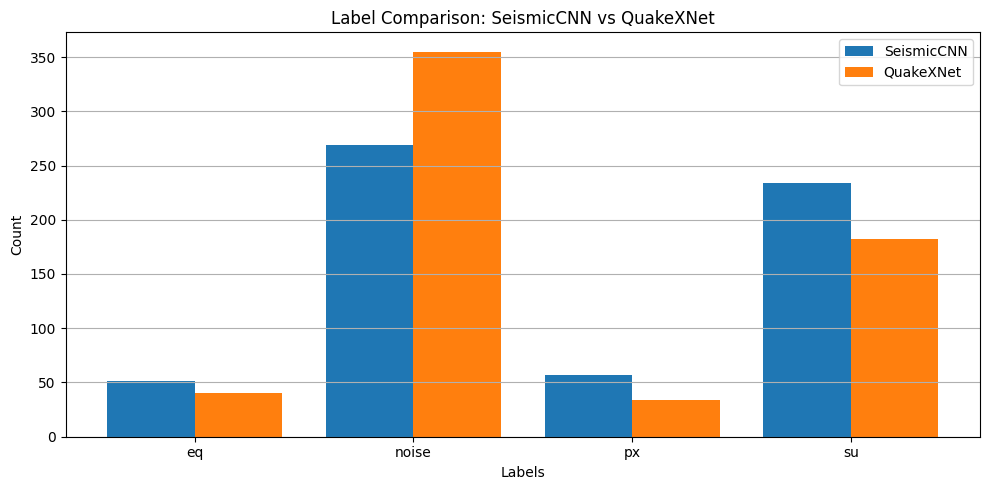

In [43]:
# Get label counts
sc_counts = df_sc['label'].value_counts().sort_index()
qx_counts = df_qx['label'].value_counts().sort_index()

# Ensure both have same labels
labels = sorted(set(sc_counts.index).union(qx_counts.index))
sc_counts = sc_counts.reindex(labels, fill_value=0)
qx_counts = qx_counts.reindex(labels, fill_value=0)

# Bar positions
x = range(len(labels))
width = 0.4

# Plot
plt.figure(figsize=(10, 5))
plt.bar([i - width/2 for i in x], sc_counts, width=width, label='SeismicCNN')
plt.bar([i + width/2 for i in x], qx_counts, width=width, label='QuakeXNet')

# Customize
plt.xticks(ticks=x, labels=labels)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Comparison: SeismicCNN vs QuakeXNet')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


<Axes: >

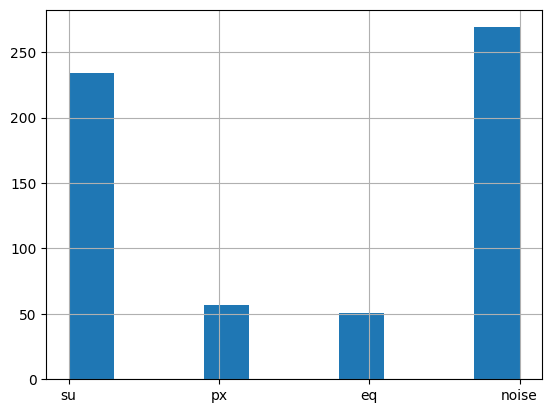

In [ ]:
results = []
client = Client('IRIS')
plot = True
n = 200

for evt_id, station in tqdm(zip(event_ids[:n], stn_list[:n]), total=n):
    chn_list = glob(
        f"../../data/pnw_new_explosion_2023_2025/waveforms/{evt_id}/*{station}*"
    )

    if len(chn_list) != 3:            # skip if 3-component stream not found
        continue


    # build & sort a 3-component Stream
    st = obspy.Stream()
    for chn in chn_list:
        st += obspy.read(chn)
    st.sort(["channel"])

    starttime = st[0].stats.starttime - 130
    endtime = st[0].stats.endtime
    network = st[0].stats.network
    station = st[0].stats.station
    channel = st[0].stats.channel[:2]+'*'

             # Download waveform for one station
    st = client.get_waveforms(
        network=network, station=station,
        location="*", channel=channel,
        starttime=starttime, endtime=endtime,
        attach_response=False
    )


    probs_st = model3.annotate(st, stride = 500)



    # Collect stats
    total_auc = {}
    mean_probs = {}
    max_probs = {}

    for cls in class_names:
        total_auc[cls] = 0.0
        mean_probs[cls] = []
        max_probs[cls] = []

        probs = probs_st.select(channel=channel_map[cls])

        for prob in probs:
            probs_array = np.array(prob)
            s_cls = smooth_moving_avg(probs_array)
            events = detect_event_windows(s_cls)

            for event in events:
                total_auc[cls] += event['area_under_curve']
                mean_probs[cls].append(event['mean_prob'])
                max_probs[cls].append(event['max_prob'])

 
    # Final label by max of max_probs
    max_probs_final = {cls: max(max_probs[cls]) if max_probs[cls] else 0 for cls in class_names}
    final_label = max(max_probs_final, key=max_probs_final.get)

    # Summarize statistics
    stats = {
        'evt_id': evt_id,
        'network': network,
        'station': station,
        'label': final_label,
    }

    for cls in class_names:
        stats[f'{cls}_auc'] = total_auc[cls]
        stats[f'{cls}_mean'] = np.mean(mean_probs[cls]) if mean_probs[cls] else 0
        stats[f'{cls}_max'] = np.max(max_probs[cls]) if max_probs[cls] else 0

    # Append result
    results.append(stats)




    if plot:
        # Select the Z component trace
        st.detrend('linear')
        st.taper(0.01)
        st.filter('bandpass', freqmin = 1, freqmax = 20)
        trace_z = st.select(channel='*HZ')[0]


        d = abs(trace_z.data)
        sr = trace_z.stats.sampling_rate
        
        # so basically we are taking the mean of absolute waveform between (200 - 250s, signal arrival time) and (100 - 150s)
        snr = np.mean(d[int(200*sr):int(250*sr)]/d[int(100*sr):int(150*sr)])
        
        
        
        
        trace_data = trace_z.data
        trace_times = np.linspace(0, len(trace_data)/trace_z.stats.sampling_rate, len(trace_data))

        # Collect smoothed probabilities (must be done earlier)
        smoothed_probs = {}
        for cls in class_names:
            probs = probs_st.select(channel=channel_map[cls])
            smoothed_all = []
            for prob in probs:
                probs_array = np.array(prob)
                s_cls = smooth_moving_avg(probs_array)
                smoothed_all.append(s_cls)
            if smoothed_all:
                smoothed_probs[cls] = np.mean(smoothed_all, axis=0)  # average across multiple channels if needed
            else:
                smoothed_probs[cls] = np.zeros(1)

        # Plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

        # Plot Z-component waveform
        ax1.plot(trace_times, trace_data, label='Z Trace', color='black')
        ax1.set_ylabel("Amplitude")
        ax1.set_title(f"Waveform and Class Probabilities\nEvent {evt_id}, Station {network}.{station}, Assigned label {final_label}, px mean {stats['px_mean']}, px max {stats['px_max']}, su mean{stats['su_mean']}, su max{stats['su_max']}")

        # Plot smoothed probabilities

        prob_times = probs_st[0].times()

        ax2.plot(prob_times + 50, smoothed_probs['eq'], label='eq')
        ax2.plot(prob_times + 50, smoothed_probs['px'], label='px')
        ax2.plot(prob_times +50, smoothed_probs['su'], label='su')
        ax2.set_ylabel("Smoothed Probabilities")
        ax2.set_xlabel("Time (s)")
        ax2.legend()

        plt.tight_layout()
        plt.show()

  





In [ ]:
# ── 1. load every model you need ────────────────────────────────────────────
models = {
    "m2": sbm.SeismicCNN.from_pretrained("base",  version_str="2"),
    "m3": sbm.SeismicCNN.from_pretrained("base",  version_str="3"),
}

# ── 2. nested dict:  {(event, station): {model_name: probs}}
probs_global = {}

for event_id in tqdm(event_ids):
    file_list = glob(f"../../data/iris_esec_waveforms/waveforms/{event_id}/*")

    # unique station codes in this event directory
    station_codes = {
        re.match(r"[A-Z0-9]+\.(\w+)", Path(f).name).group(1)
        for f in file_list
        if re.match(r"[A-Z0-9]+\.(\w+)", Path(f).name)
    }

    for stn in sorted(station_codes):
        chn_list = glob(f"../../data/iris_esec_waveforms/waveforms/{event_id}/*{stn}*")

        if len(chn_list) != 3:          # need exactly Z/N/E
            continue

        try:
            st = obspy.Stream()
            for chn in chn_list:
                st += obspy.read(chn)
            st.sort(["channel"])

            # annotate with every model and store under its name
            for name, mdl in models.items():
                probs = np.asarray(mdl.annotate(st, stride = 1000))          # (n_classes, n_windows)
                probs_global.setdefault((event_id, stn), {})[name] = probs

        except Exception as e:
            print(f"[{event_id} | {stn}] → {e}")


## Computing the probabilities

In [ ]:
CLASS_IDX   = {"eq": 0, "px": 1, "noise": 2, "surface": 3}
PRIORITY    = ["eq", "px", "surface"]     # which classes can be the “winner”
MODELS_USED = ["m2", "m3"]                # adapt if you add more

def _winner_label(class_probs, thr):
    """Return label string given a dict {cls:prob}."""
    # consider only eq, px, surface for max decision
    max_cls = max(PRIORITY, key=lambda c: class_probs[c])
    return max_cls if class_probs[max_cls] > thr else "noise"

def process_probabilities(probs_dict, threshold=0.5):
    rows = []

    for (event_id, station), model_dict in probs_dict.items():
        row            = {"event_id": event_id, "station": station}
        ensemble_store = {cls: [] for cls in CLASS_IDX}   # collect per-model max

        # ── per-model columns ───────────────────────────────────────────
        for mdl_name in MODELS_USED:
            if mdl_name not in model_dict:
                continue                                  # skip missing model

            probs = model_dict[mdl_name]
            if probs.shape[0] > 4:                       # transpose if needed
                probs = probs.T

            # max over windows
            cls_max = {
                "eq"     : probs[CLASS_IDX["eq"]    ].mean(),
                "px"     : probs[CLASS_IDX["px"]    ].mean(),
                "noise"  : probs[CLASS_IDX["noise"] ].mean(),
                "surface": probs[CLASS_IDX["surface"]].mean(),
            }

            # add to row
            row[f"prob_eq_{mdl_name}"]  = cls_max["eq"]
            row[f"prob_px_{mdl_name}"]  = cls_max["px"]
            row[f"prob_noise_{mdl_name}"]  = cls_max["noise"]
            row[f"prob_surface_{mdl_name}"]  = cls_max["surface"]
            
            row[f"max_prob_{mdl_name}"] = max(cls_max[c] for c in PRIORITY)
            row[f"assigned_label_{mdl_name}"] = _winner_label(cls_max, threshold)

            # accumulate for ensemble
            for cls, val in cls_max.items():
                ensemble_store[cls].append(val)

        # ── ensemble mean columns ───────────────────────────────────────
        ens_mean = {cls: float(np.mean(vals)) for cls, vals in ensemble_store.items()}
        row["prob_eq_ens"]     = ens_mean["eq"]
        row["prob_px_ens"]     = ens_mean["px"]
        row["prob_noise_ens"]  = ens_mean["noise"]
        row["prob_surface_ens"]= ens_mean["surface"]
        row["max_prob_ens"]    = max(ens_mean[c] for c in PRIORITY)
        row["assigned_label_ens"] = _winner_label(ens_mean, threshold)

        rows.append(row)

    return pd.DataFrame(rows)


In [ ]:
labels_df = process_probabilities(probs_global, threshold = 0.1)

In [ ]:
labels_df

In [ ]:
# ------------------------------------------------------------------
# 1.  Select the model-label columns you want to compare
# ------------------------------------------------------------------
model_cols = [
    "assigned_label_m2",
    "assigned_label_m3",
]

# ------------------------------------------------------------------
# 2.  Filter rows (SNR > 7) and reshape to long form
# ------------------------------------------------------------------
filtered = labels_df.copy()

long_df = filtered.melt(
    value_vars=model_cols,
    var_name="model",
    value_name="assigned_label"
)

# Clean model names for nicer legend labels
long_df["model"] = (
    long_df["model"]
    .str.replace("assigned_label_", "", regex=False)  # m2 → m2, ens → ens
)

# Establish a consistent label order (eq / px / surface / noise)
label_order = ["eq", "px", "surface", "noise"]

# ------------------------------------------------------------------
# 3.  Plot
# ------------------------------------------------------------------
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))

ax = sns.countplot(
    data=long_df,
    x="assigned_label",
    hue="model",
    order=label_order,
    palette="pastel"
)

# ------------------------------------------------------------------
# 4.  Annotate bar heights
# ------------------------------------------------------------------
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

# ------------------------------------------------------------------
# 5.  Cosmetics
# ------------------------------------------------------------------
plt.title("Assigned-Label Distribution per Model", weight="bold")
plt.xlabel("Assigned Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Model", bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()


## Figuring out which events were mislabelled by m2 and why?

In [ ]:
miss_label_m2 = labels_df[labels_df['assigned_label_m2'] == 'surface']

In [ ]:
miss_label_m2

In [ ]:
miss_label_m2[miss_label_m2['event_id'] == 272]

In [ ]:
np.unique(miss_label_m2['event_id'].values, return_counts = True)

## Plotting the waveforms to see what is going on

In [ ]:
cat[cat['eventid'] == 272]['starttime']

In [ ]:
st

In [ ]:
start = '2014-07-21T23:24:04'
starttime = obspy.UTCDateTime(start) - 200
endtime = obspy.UTCDateTime(start) + 200
network = '*'
station = 'BOTN'
channel = '*H*'
loc = '*'

client = Client('IRIS')
st = client.get_waveforms(starttime = starttime, 
                    endtime = endtime, 
                    network = network, 
                    station = station, 
                    channel = channel, 
                    location = loc)

In [ ]:
st

In [ ]:
#model1 = sbm.QuakeXNetoneD.from_pretrained("base")

model1 = sbm.SeismicCNN.from_pretrained("base", version_str = '1')
model2 = sbm.SeismicCNN.from_pretrained("base", version_str = '2')
model3 = sbm.SeismicCNN.from_pretrained("base", version_str = '3')
model4 = sbm.SeismicCNN.from_pretrained("base", version_str = '4')
model5 = sbm.SeismicCNN.from_pretrained("base", version_str = '5')
model6 = sbm.SeismicCNN.from_pretrained("base", version_str = '6')

In [ ]:
model3.annotate(st, stride = 200).plot();

In [ ]:
probs = np.array(model3.annotate(st, stride = 200))
probs_st = model3.annotate(st, stride = 200)

In [ ]:
probs_st[0].times()

In [ ]:
st.detrend('linear')
st.taper(0.1)
st.filter('bandpass', freqmin = 1, freqmax = 10)
st.plot()

In [ ]:
sns.set_style("whitegrid")
sns.set_context("talk")

# ---------------------------------------------------------
# Pre-compute once
# ---------------------------------------------------------
wave_t  = st[2].times()                                        # vertical comp. time axis
wave_y  = st[2].data / np.abs(st[2].data).max()                # normalised amplitude

prob_t  = probs_st[2].times() + 50                             # add 50-s alignment shift
prob_px = probs[1]                                             # explosion class
prob_su = probs[3]                                             # surface class

# ---------------------------------------------------------
# Figure
# ---------------------------------------------------------
fig, (ax0, ax1) = plt.subplots(
    2, 1, figsize=(12, 5), sharex=True,
    gridspec_kw={"height_ratios": [1, 2], "hspace": 0.05}
)

# 1) waveform
ax0.plot(wave_t, wave_y, color="black", lw=0.8)
ax0.set_ylabel("Norm. amplitude")
ax0.set_title("Waveform & class probabilities", weight="bold")
ax0.set_ylim(-1.1, 1.1)
ax0.tick_params(axis="x", which="both", length=0)

# 2) probabilities
ax1.plot(prob_t, prob_px, label="Explosion $P_{px}$",  lw=2, color=sns.color_palette("Set2")[1])
ax1.plot(prob_t, prob_su, label="Surface  $P_{su}$",  lw=2, color=sns.color_palette("Set2")[0])

ax1.axhline(0.5, color="gray", ls="--", lw=0.8)                # guide threshold
ax1.set_xlabel("Time since trace start (s)")
ax1.set_ylabel("Probability")
ax1.set_ylim(0, 1.02)
ax1.legend(frameon=False, loc="upper right")

sns.despine()
plt.tight_layout()
plt.show()


In [ ]:
fs = tr_z.stats.sampling_rate                # samples / s (e.g. 100 Hz)

# --- analytic envelope ---
raw_env = np.abs(hilbert(tr_z.data))

# --- smooth: 5-second Savitzky–Golay (choose what suits your fs) ---
win   = int(5 * fs) | 1                      # window must be odd
smooth_env = savgol_filter(raw_env, win, 3)

smooth_env = smooth_env / smooth_env.max()   # normalise for plotting




sns.set_style("whitegrid")
sns.set_context("talk")

# ------------------------------------------------------------------
# 1.  Waveform & envelope
# ------------------------------------------------------------------
tr_z   = st.select(component="Z")[0]           # vertical component
wave_t = tr_z.times()
wave_y = tr_z.data / np.abs(tr_z.data).max()

env_y  = envelope(tr_z.data)                   # instantaneous amplitude
env_y  = env_y / env_y.max()                   # normalise 0-1

# ------------------------------------------------------------------
# 2.  Probabilities (already computed by your model)
# ------------------------------------------------------------------
prob_t  = probs_st[2].times() + 50             # alignment shift
prob_px = probs[1]                             # explosion class
prob_su = probs[3]                             # surface class

# ------------------------------------------------------------------
# 3.  Figure
# ------------------------------------------------------------------
fig, (ax0, ax1) = plt.subplots(
    2, 1, figsize=(12, 5), sharex=True,
    gridspec_kw=dict(height_ratios=[1, 2], hspace=0.05)
)

# ── top panel: waveform + envelope ────────────────────────────────
ax0.plot(wave_t, wave_y, color="black", lw=0.8, label="Waveform (Z)")
ax0.plot(wave_t, smooth_env, color="darkorange", lw=1.5, label="Smooth envelope")
ax0.set_ylabel("Norm. amplitude")
ax0.set_ylim(-1.1, 1.1)
ax0.set_title("Waveform, Envelope & Class Probabilities", weight="bold")
ax0.legend(frameon=False, loc="upper right")
ax0.tick_params(axis="x", length=0)

# ── bottom panel: class probabilities ─────────────────────────────
ax1.plot(prob_t, prob_px, label="Explosion $P_{px}$",
         lw=2, color=sns.color_palette("Set2")[1])
ax1.plot(prob_t, prob_su, label="Surface  $P_{su}$",
         lw=2, color=sns.color_palette("Set2")[0])

ax1.axhline(0.5, color="gray", ls="--", lw=0.8)      # threshold guide
ax1.set_xlabel("Time since trace start (s)")
ax1.set_ylabel("Probability")
ax1.set_ylim(0, 1.02)
ax1.legend(frameon=False, loc="upper right")

sns.despine()
plt.tight_layout()
plt.show()


In [ ]:
raw_env = np.abs(hilbert(tr_z.data))          # 1) instantaneous envelope
smooth_env = savgol_filter(                   # 2)  apply Savitzky-Golay
    raw_env, window_length=501, polyorder=3)  #    (≈5 s @ 100 Hz)
smooth_env /= smooth_env.max()                # 0–1 normalisation


In [ ]:
ax0.plot(wave_t, smooth_env, color="darkorange", lw=1.5, label="Smooth envelope")


In [ ]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy.signal import hilbert, savgol_filter

sns.set_style("whitegrid")
sns.set_context("talk")

# ───── Waveform + smooth envelope ──────────────────────────────────────────
tr_z   = st.select(component="Z")[0]
fs     = tr_z.stats.sampling_rate
wave_t = tr_z.times()
wave_y = tr_z.data / np.abs(tr_z.data).max()

raw_env    = np.abs(hilbert(tr_z.data))
win        = int(5 * fs) | 1            # ~5-s Savitzky window, must be odd
smooth_env = savgol_filter(raw_env, win, 3)
smooth_env = smooth_env / smooth_env.max()

# ───── Probabilities (already from model3) ─────────────────────────────────
prob_t  = probs_st[2].times() + 50       # (Nwin,) time stamps
prob_px = probs[1]                       # explosion P_px  (Nwin,)
prob_su = probs[3]                       # surface   P_su  (Nwin,)

# ───── Resample envelope onto prob grid & weight ───────────────────────────
env_resamp = np.interp(prob_t, wave_t, smooth_env)
w_px = prob_px * env_resamp
w_su = prob_su * env_resamp

# ───── Plot ----------------------------------------------------------------
fig, (ax0, ax1, ax2) = plt.subplots(
    3, 1, figsize=(12, 7), sharex=True,
    gridspec_kw=dict(height_ratios=[1, 2, 2], hspace=0.05)
)

# 1) waveform + envelope
ax0.plot(wave_t, wave_y, color="black", lw=0.8, label="Waveform (Z)")
ax0.plot(wave_t, smooth_env, color="darkorange", lw=1.4, label="Envelope")
ax0.set_ylim(-1.1, 1.1)
ax0.set_ylabel("Norm. amp.")
ax0.set_title("Waveform, Envelope, Probabilities & Envelope-weighted Prob.", weight="bold")
ax0.legend(frameon=False, loc="upper right")
ax0.tick_params(axis="x", length=0)

# 2) raw probabilities
ax1.plot(prob_t, prob_px, lw=2, label="Explosion $P_{px}$",
         color=sns.color_palette("Set2")[1])
ax1.plot(prob_t, prob_su, lw=2, label="Surface  $P_{su}$",
         color=sns.color_palette("Set2")[0])
ax1.axhline(0.5, color="gray", ls="--", lw=0.8)
ax1.set_ylabel("Probability")
ax1.set_ylim(0, 1.02)
ax1.legend(frameon=False, loc="upper right")

# 3) envelope-weighted probabilities
ax2.plot(prob_t, w_px, lw=2, label="$P_{px}\\times$Env.",
         color=sns.color_palette("Set2")[1])
ax2.plot(prob_t, w_su, lw=2, label="$P_{su}\\times$Env.",
         color=sns.color_palette("Set2")[0])
ax2.set_xlabel("Time since trace start (s)")
ax2.set_ylabel("Env-weighted Prob.")
ax2.set_ylim(0, 1.02)
ax2.legend(frameon=False, loc="upper right")

sns.despine()
plt.tight_layout()
plt.show()


In [ ]:
event_id = 307
station = 'A060B'
files = glob(f"../../data/iris_esec_waveforms/waveforms/{event_id}/*{station}*")
st = []

for file in files:
    st += obspy.read(file)
    
st = obspy.Stream(st)

In [ ]:
st.detrend('linear')
st.filter('bandpass', freqmin = 1, freqmax = 20)
st.plot();

In [ ]:
model2.annotate(st, stride = 100).plot();

In [ ]:
model3.annotate(st, stride = 100).plot();

In [ ]:
st

In [ ]:
# Example usage:
labels_df = process_probabilities(probs_global)
labels_df.head()
print(len(labels_df))

In [ ]:
labels_df.to_csv('../seisbench_output/esec_event_output_labels_from_retrained_model.csv')

In [ ]:
def plot_trace(tr):
    # Assuming `tr` is your ObsPy Trace object
    data = tr[0].data  # Amplitude values
    npts = tr[0].stats.npts  # Number of samples
    sampling_rate = tr[0].stats.sampling_rate  # Samples per second

    # Create time axis in seconds
    time = np.linspace(0, npts / sampling_rate, npts)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, data, linewidth=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"{tr[0].stats.station}.{tr[0].stats.channel} | {tr[0].stats.starttime}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    
snr = []
for i in tqdm(range(len(labels_df))):
#for i in tqdm(range(100, 150)):    
    event_id = labels_df['event_id'].values[i]
    station = labels_df['station'].values[i]
    files = glob(f'../../data/iris_esec_waveforms/waveforms/{event_id}/*{station}*HN*')
    tr = obspy.read(files[0])
    tr.resample(50)
    tr.detrend('linear')
    tr.taper(0.05)
    tr.filter('bandpass', freqmin = 1, freqmax = 20)

    #plot_trace(tr)
    #print(label)
    # snr - signal to noise ratio
    d = tr[0].data
    
    #snr = np.max(abs(d[3000:8000]))/np.sqrt(np.mean(abs(d[1000:2000])**(2)))
    #print(snr)
    
    snr.append(np.max(abs(d[3000:8000]))/np.sqrt(np.mean(abs(d[1000:2000])**(2))))
    
labels_df['snr_n'] = snr

In [ ]:
sns.boxplot(data=labels_df, x="assigned_label_m2", y="snr_n")
plt.title("SNR Distribution per Label")
plt.ylim(0,100)
plt.ylabel("SNR")
plt.xlabel("Label")
plt.show()


In [ ]:
good_df_m3 = labels_df[labels_df['assigned_label_m3'] == 'surface']

In [ ]:
good_df_m3

In [ ]:
probs_global[302, 'IOCA']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------------------------------------------------
# 1.  Select the model-label columns you want to compare
# ------------------------------------------------------------------
model_cols = [
    "assigned_label_m2",
    "assigned_label_m3",
    "assigned_label_ens",   # ensemble-mean
    "assigned_label_m5",    # add/remove as needed
    "assigned_label_m6"
]

# ------------------------------------------------------------------
# 2.  Filter rows (SNR > 7) and reshape to long form
# ------------------------------------------------------------------
filtered = labels_df[labels_df["snr_n"] > 7].copy()

long_df = filtered.melt(
    value_vars=model_cols,
    var_name="model",
    value_name="assigned_label"
)

# Clean model names for nicer legend labels
long_df["model"] = (
    long_df["model"]
    .str.replace("assigned_label_", "", regex=False)  # m2 → m2, ens → ens
)

# Establish a consistent label order (eq / px / surface / noise)
label_order = ["eq", "px", "surface", "noise"]

# ------------------------------------------------------------------
# 3.  Plot
# ------------------------------------------------------------------
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))

ax = sns.countplot(
    data=long_df,
    x="assigned_label",
    hue="model",
    order=label_order,
    palette="pastel"
)

# ------------------------------------------------------------------
# 4.  Annotate bar heights
# ------------------------------------------------------------------
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="bold"
    )

# ------------------------------------------------------------------
# 5.  Cosmetics
# ------------------------------------------------------------------
plt.title("Assigned-Label Distribution per Model (SNR > 7)", weight="bold")
plt.xlabel("Assigned Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Model", bbox_to_anchor=(1.04, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
good_df  = labels_df[labels_df['snr_n'] > 7]
mean_probs = good_df.groupby('event_id')[['prob_eq', 'prob_px', 'prob_surface']].mean()

# Step 2: Identify the label with the highest mean probability (excluding noise)
mean_probs['event_label'] = mean_probs.idxmax(axis=1).str.replace('prob_', '')

# Optional: merge back into original DataFrame if needed
good_df = good_df.merge(mean_probs['event_label'], on='event_id', how='left')

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=mean_probs, x='event_label', palette='Set2')

plt.title('Distribution of Event Labels (Based on Mean Probabilities)', fontsize=14)
plt.xlabel('Event Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
good_df

In [ ]:
def plot_event_waveforms(event_id, labels_df, savepath = '../seisbench_output/esec_classification_figures/earthquake/'):
    # Filter rows for this event
    subset = labels_df[labels_df['event_id'] == event_id]
    
    event_type = cat[cat['eventid'] == event_id]['type'].values[0]
    if subset.empty:
        print(f"No data found for event {event_id}")
        return
    
    # Get event-level label from the first row
    event_label = subset['event_label'].iloc[0]
    
    fig, ax = plt.subplots(figsize=(12, 1.8 * len(subset)))
    
    for idx, row in subset.iterrows():
        station = row['station']
        
        # Find the vertical-component HZ file
        files = glob(f'../../data/iris_esec_waveforms/waveforms/{event_id}/*{station}*HZ*')
        if not files:
            print(f"No HZ component found for {station} in event {event_id}")
            continue
        
        try:
            tr = obspy.read(files[0])[0]
            tr.resample(50)
            tr.detrend('linear')
            tr.taper(0.05)
            tr.filter('bandpass', freqmin=1, freqmax=20)
            data = tr.data
            times = np.arange(len(data)) / tr.stats.sampling_rate

            # Offset the waveform vertically
            offset = idx
            ax.plot(times, data / np.max(np.abs(data)) + offset, lw=0.8, color='steelblue')

            # Format the label with probabilities
            prob_text = f"{station} | eq:{row['prob_eq']:.2f} px:{row['prob_px']:.2f} su:{row['prob_surface']:.2f}"
            ax.text(times[-1] + 2, offset, prob_text, va='center', fontsize=8)

        except Exception as e:
            print(f"Error loading {station} for event {event_id}: {e}")
            continue
    
    ax.set_title(f"Event {event_id} | Label: {event_label.upper()} | Event Type: {event_type}", fontsize=14, weight='bold')
    ax.set_xlabel("Time (s)")
    ax.set_yticks([])  # Remove numerical ticks; we use text annotations
    ax.set_ylabel("Stations (vertical offset)")
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    # Ensure save directory exists
    os.makedirs(savepath, exist_ok=True)
    # Now save
    plt.savefig(os.path.join(savepath, f'{event_id}_from_retrained.png'))
    
    plt.close()

In [ ]:
eq_df = mean_probs[mean_probs['event_label'] == 'eq']
px_df = mean_probs[mean_probs['event_label'] == 'px']
su_df = mean_probs[mean_probs['event_label'] == 'surface']

In [ ]:
event_ids = eq_df.index.values
for evid in event_ids:
    plot_event_waveforms(event_id= evid, labels_df= good_df, savepath = '../seisbench_output/esec_classification_figures/earthquake/')

    
event_ids = px_df.index.values
for evid in event_ids:
    plot_event_waveforms(event_id= evid, labels_df= good_df, savepath = '../seisbench_output/esec_classification_figures/explosion/')

    
event_ids = su_df.index.values
for evid in event_ids:
    plot_event_waveforms(event_id= evid, labels_df= good_df, savepath = '../seisbench_output/esec_classification_figures/surface/')